In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

In [39]:
#Final = pd.read_pickle("../data/Final.pkl")
Final = pd.read_pickle("../data/Final_5.pkl")

# Results!

In [145]:
Stats = Final[['Season', 'Receiver', 'Nearest_Defender', 'Separation', 'Pred_Sep', 'TD', 'Pass Yds', 'INT', 'Cmp', 'Team', 'Air_Yds', 'Cushion']]
Stats['Sep_Diff'] = Stats['Separation'] - Stats['Pred_Sep']

In [146]:
COUNT_df = Stats.groupby(['Receiver', 'Season']).nunique()
COUNT_df = COUNT_df.rename(columns = {'Separation':'Targets'})
COUNT_df = COUNT_df[['Targets']]
Final_df = Stats.merge(COUNT_df, on = ['Receiver', 'Season'])

### Year over Year stability of Separation Differential

Below is a table showing how correlated a receivers average Separation Differential is year-over-year. Turns out, among receievers with at least 70 targets in each of the last 3 years, there is a low, but non-zero correlation between those figures over three seasons. Considering the variable nature of separation, this is to be expected, but I would be worth looking into why these correlation values aren't more stable year over year.

In [147]:
YoY = Final_df[Final_df['Targets'] >= 70]
YoY = YoY.groupby(['Receiver', 'Season'])[['Separation', 'Pred_Sep', 'Sep_Diff']].mean()
YoY = pd.pivot_table(YoY, values='Sep_Diff',index='Receiver', columns=['Season']).corr().round(3)
YoY

Season,2017,2018,2019
Season,,,
2017,1.000,0.338,0.29
2018,0.338,1.000,0.45
2019,0.290,0.450,1.00


### How do the players stack up?

In [148]:
Season = Final_df[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff', 'Season', 'Targets']]
Season = Season.groupby(['Receiver', 'Season']).mean().reset_index().round(2)

In [149]:
#Create df since 2017

Since17 = Stats[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff']]
Since17_df = Since17.groupby(['Receiver']).mean().reset_index().round(2)
COUNT = Stats.groupby(['Receiver']).nunique()
COUNT = COUNT.rename(columns = {'Separation':'Targets'})
COUNT_1 = COUNT[['Targets']]
Since17_df = Since17_df.merge(COUNT_1, on = ['Receiver'])

## Top 10 Highest Average Separation Above Expectation since 2017

In [150]:
Career = Since17_df[Since17_df['Targets'] > 170].sort_values(['Sep_Diff'], ascending = False)
Career.head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
584,Sammy Watkins,2.96,2.55,0.42,253
666,Tyreek Hill,3.26,2.87,0.38,373
679,Will Fuller,2.95,2.59,0.36,174
180,Davante Adams,3.04,2.69,0.35,432
623,Ted Ginn,3.02,2.73,0.29,188
138,Cooper Kupp,3.34,3.08,0.26,296
195,DeSean Jackson,2.77,2.51,0.26,172
94,Calvin Ridley,3.02,2.78,0.24,184
25,Amari Cooper,2.76,2.55,0.22,336
665,Tyler Lockett,3.11,2.90,0.22,270


## Top 10 Lowest Average Separation Above Expectation

In [151]:
Career.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
264,Golden Tate,2.66,3.17,-0.51,324
98,Cameron Brate,2.61,3.02,-0.41,175
429,Larry Fitzgerald,2.60,3.00,-0.40,378
561,Rob Gronkowski,2.39,2.74,-0.35,209
21,Allen Robinson,2.14,2.45,-0.31,260
499,Mike Williams,1.95,2.20,-0.25,194
320,Jared Cook,2.75,3.00,-0.25,254
196,DeVante Parker,2.22,2.46,-0.24,267
413,Kenny Golladay,2.12,2.35,-0.23,273
469,Marvin Jones,2.14,2.31,-0.17,258


## 2019 Only

In [152]:
df_2019 = Season[(Season['Targets'] > 85) & (Season['Season'] == 2019)].sort_values(['Sep_Diff'], ascending = False).reset_index(drop = True)
df_2019.head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
0,Davante Adams,2019,3.31,2.75,0.55,149
1,Diontae Johnson,2019,3.62,3.10,0.52,92
2,Tyler Higbee,2019,3.70,3.24,0.46,88
3,Tyreek Hill,2019,3.23,2.77,0.46,114
4,Christian Kirk,2019,3.48,3.07,0.41,106
5,Travis Kelce,2019,3.02,2.68,0.34,157
6,Sammy Watkins,2019,3.03,2.76,0.28,108
7,John Brown,2019,2.47,2.24,0.23,123
8,Tyler Lockett,2019,3.13,2.90,0.23,126
9,Cooper Kupp,2019,3.39,3.17,0.21,134


In [153]:
df_2019.sort_values(['Sep_Diff'], ascending = True).head(5)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
53,Marvin Jones,2019,2.09,2.55,-0.47,91
52,Mike Gesicki,2019,2.62,3.03,-0.41,89
51,Julio Jones,2019,2.16,2.48,-0.31,156
50,Kenny Golladay,2019,1.95,2.22,-0.27,113
49,DeVante Parker,2019,2.03,2.29,-0.26,126


# Exceptional Separation Rate

'Exceptional Separation Rate' that tallies all the instances where a receiver exceeds their predicted separation, and divide that by their total targets to see how often they are exceeding expectations. This metric will be **less prone to outliers**.

In [239]:
Final_ES = Stats.copy()
Final_ES['ES'] = 0
Final_ES['ES'].loc[Final_ES['Sep_Diff']> 0] = 1
Final_ES = Final_ES.merge(COUNT_1, on = ['Receiver'])
Final_ES = Final_ES[['Receiver', 'ES', 'Targets', 'Sep_Diff', 'Separation', 'Pred_Sep', 'Pass Yds', 'Air_Yds', 'Cmp', 'Cushion']]
Final_ES = Final_ES.groupby(['Receiver']).mean().round(3)
Final_ES['ES'] = (Final_ES['ES']*100).round(3)
Final_ES = Final_ES[Final_ES['Targets'] >= 170]
Final_ES = Final_ES.sort_values(['ES'], ascending = False).reset_index()
Final_ES.head(10)

,Receiver,ES,Targets,Sep_Diff,Separation,Pred_Sep,Pass Yds,Air_Yds,Cmp,Cushion
0,Ted Ginn,53.2,188.0,0.287,3.016,2.729,9.170,14.713,0.633,7.006
1,Davante Adams,52.4,432.0,0.349,3.037,2.688,8.236,10.370,0.658,5.295
2,Sammy Watkins,52.2,253.0,0.416,2.964,2.548,8.980,11.251,0.617,5.233
3,Tyreek Hill,51.2,373.0,0.383,3.258,2.874,10.211,13.119,0.651,6.184
4,DeSean Jackson,49.7,172.0,0.257,2.767,2.509,9.249,17.222,0.572,7.275
5,Calvin Ridley,49.5,184.0,0.237,3.021,2.783,9.109,11.823,0.685,6.856
6,Christian Kirk,49.4,174.0,0.119,3.180,3.061,7.466,9.279,0.638,6.078
7,Cooper Kupp,49.3,296.0,0.260,3.343,3.082,9.047,8.171,0.689,6.755
8,Will Fuller,48.9,174.0,0.357,2.950,2.593,9.684,14.515,0.655,5.464
9,Keelan Cole,46.6,192.0,0.126,2.862,2.736,8.715,11.403,0.554,6.296


In [240]:
Final_ES.sort_values(['ES'], ascending = True).head(10)

,Receiver,ES,Targets,Sep_Diff,Separation,Pred_Sep,Pass Yds,Air_Yds,Cmp,Cushion
78,Rob Gronkowski,30.7,209.0,-0.345,2.390,2.736,9.712,11.543,0.642,5.021
77,Larry Fitzgerald,30.8,378.0,-0.400,2.596,2.996,7.089,8.378,0.666,6.139
76,Kenny Golladay,31.1,273.0,-0.226,2.121,2.347,9.746,14.152,0.579,5.183
75,Devin Funchess,31.7,201.0,-0.102,2.381,2.483,7.426,12.982,0.564,5.849
74,Golden Tate,31.7,324.0,-0.508,2.664,3.173,7.631,7.098,0.671,5.980
73,DeVante Parker,32.6,267.0,-0.244,2.216,2.460,8.030,12.958,0.563,5.110
72,Mike Williams,32.8,194.0,-0.252,1.951,2.204,9.590,15.794,0.564,5.024
71,Cameron Brate,33.1,175.0,-0.411,2.610,3.021,6.680,8.693,0.629,5.535
70,Allen Robinson,33.8,260.0,-0.306,2.143,2.450,7.904,11.492,0.627,5.285
69,Jared Cook,34.0,254.0,-0.254,2.750,3.004,9.145,9.060,0.660,5.168


## Why should you care?

The goal of this exercise is try and extract information from recevier separation, and the analysis doesn't end with these numbers. In an attmept to see how this stat looks on the team scale, I correlated *win percentage* over the last three seasons with the teams *average team separation differential* to see how this stat did to predict team success. 

In [241]:
WinPct = [.813, .750, .438, .563, .625, .438, .625, .375, .313, .875, .438, .750, 
          .688, .344, .500, .375, .500, .625, .438, .563, .438, .563, .500, .313, 
          .813, .438, .188, .125, .813, .250, .313, .219]

WP_AS = [.704, .551, .510, .490, .746, .451, .500, .560, .375, .673, .625, .354, 
         .660, .608, .440, .648, .277, .736, .540, .375, .566, .354, .647, .469, 
         .333, .500, .312, .354, .250, .510, .340, .383]

Teams = ['KC','GB','HOU','SF','NE','JAX','ATL','DAL','DEN','LA','PIT','TB','BAL',
         'SEA','IND','PHI','CLE','NO','LAC','MIA','TEN','OAK','MIN','CAR','NYJ',
         'BUF','CIN','WAS','NYG','CHI','ARI','DET']


d = {'Team': Teams, 'Win Pct Since 2017': WP_AS}
Three_Year = pd.DataFrame(d)

In [242]:
Teams = Stats[['Separation', 'Pred_Sep','Team']]
Teams['Sep Above Expectation'] = Teams['Separation'] - Teams['Pred_Sep']
Team_df = Teams.groupby(['Team']).mean().sort_values(['Sep Above Expectation'], ascending = False)
Combined = Team_df.merge(Three_Year, on = 'Team')
Combined.round(3).head(32)

,Team,Separation,Pred_Sep,Sep Above Expectation,Win Pct Since 2017
0,KC,3.281,2.911,0.370,0.704
1,GB,3.200,2.963,0.236,0.551
2,LA,3.142,3.023,0.119,0.673
3,NE,2.879,2.799,0.079,0.746
4,HOU,2.902,2.823,0.079,0.510
5,SEA,2.930,2.855,0.075,0.608
6,IND,3.011,2.945,0.066,0.440
7,PIT,2.948,2.905,0.043,0.625
8,DAL,2.812,2.769,0.042,0.560
9,JAX,2.974,2.944,0.030,0.451


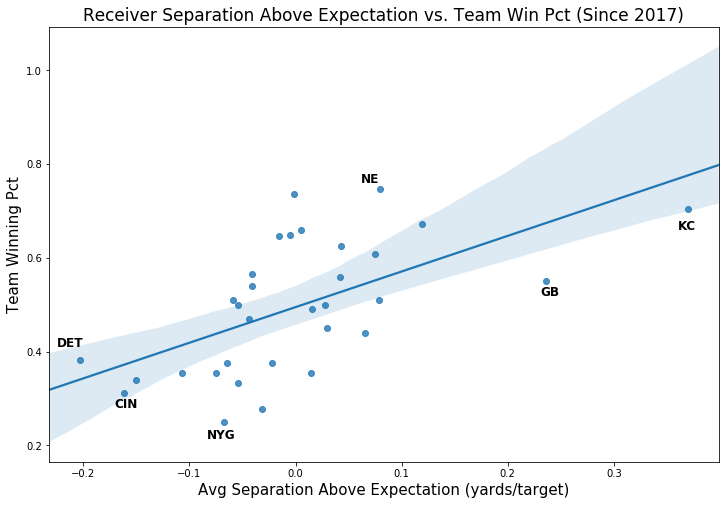

In [243]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.regplot(x= 'Sep Above Expectation', y = 'Win Pct Since 2017', data = Combined)

ax.set_title('Receiver Separation Above Expectation vs. Team Win Pct (Since 2017)', fontsize = 17)
ax.set_ylabel('Team Winning Pct', fontsize = 15)
fig.text(.36, .66, "KC", horizontalalignment='left', size='large', color='black', weight='semibold')
fig.text(-.2, .41, "DET", horizontalalignment='right', size='large', color='black', weight='semibold')
fig.text(.24, .52, "GB", horizontalalignment='center', size='large', color='black', weight='semibold')
fig.text(-.07, .215, "NYG", horizontalalignment='center', size='large', color='black', weight='semibold')
fig.text(.07, .76, "NE", horizontalalignment='center', size='large', color='black', weight='semibold')
fig.text(-.16, .28, "CIN", horizontalalignment='center', size='large', color='black', weight='semibold')
A = ax.set_xlabel('Avg Separation Above Expectation (yards/target)', fontsize = 15)

Amazingly enough, teams with higher average separation differentials **won more often** than teams with lower separation differentials.

I know what you are thinking, 
> "*of course it is! receiver separation is a good thing, so teams with higher separation win more!*"

Yes, that is true, BUT, separation differential is actually a better predictor of team success than average separation.

In [244]:
Corr = Combined.corr(method = 'spearman').round(2)
Corr

,Separation,Pred_Sep,Sep Above Expectation,Win Pct Since 2017
Separation,1.00,0.73,0.79,0.48
Pred_Sep,0.73,1.00,0.23,0.07
Sep Above Expectation,0.79,0.23,1.00,0.66
Win Pct Since 2017,0.48,0.07,0.66,1.00


## Player Evaluation

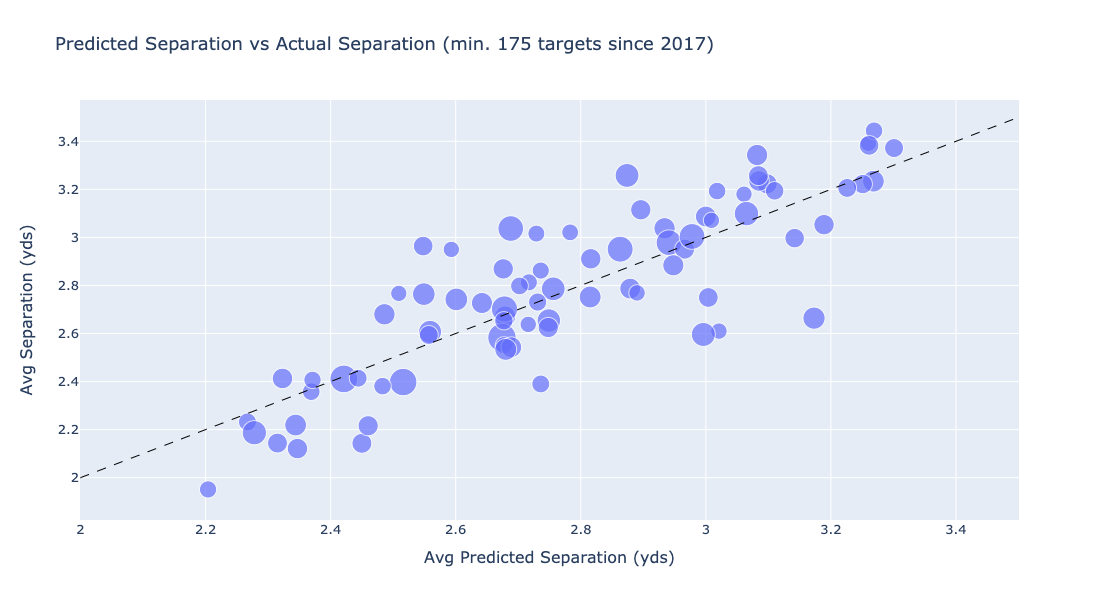

In [245]:
import plotly.express as px

fig = px.scatter(Final_ES, x="Pred_Sep", y="Separation", size="Targets",
           hover_name="Receiver", width=1000, height=600, 
                 labels={
                     "Pred_Sep":'Predicted Separation',
                     "Pass Yds": "Rec Yards Per Target",
                     "Cmp": "Catch Rate",
                     'Air_Yds': 'Average Air Yards Per Target'
                 },
                title="Predicted Separation vs Actual Separation (min. 175 targets since 2017) ")

fig.update_layout(
    xaxis_title="Avg Predicted Separation (yds)",
    yaxis_title="Avg Separation (yds)",
    font=dict(
        size=13))

fig.add_shape(
        # Diagonal line
            type="line",
            x0=2,
            y0=2,
            x1=3.5,
            y1=3.5,
            line=dict(
                color="Black",
                width=1,
                dash="dash",
            )
)

fig.show()

The interactive plot above shows the differences between predicted and actual average separations of receivers with at least 175 targets in the last three seasons. 

Players **above** the diagonal line excel at gaining separation relative to their peers. 

This could be a separate [clustering](https://en.wikipedia.org/wiki/K-means_clustering) project altogether, but you will notice 4 distinct groups of players as you travel up and to the right along the line. 

1. **Bottom Left**
    - Tall, Iso wide receviers that go deep often and operate in tight windows
        - Best Separation Differential: DeAndre Hopkins, John Brown
        - Worst Separation Differential: Kenny Golladay, Allen Robinson
2. **Middle-Left**
    - Average-sized receivers that move around (between wide, slot) more often and run a larger variety of routes
        - Best: Davante Adams, Sammy Watkins
        - Worst: Demaryius Thomas, Rob Gronkowski
3. **Middle-Right**
    - These receivers work almost exclusivly from the slot, and most tend to run shallower routes
        - Best: Tyreek Hill, Cooper Kupp
        - Worst: Larry Fitzgerald, Golden Tate
4. **Top Right**
    - Mostly Tight Ends and and exclusive Slot receivers
        - Best: Jack Doyle, Austin Hooper
        - Worst: Jamison Crowder, Kyle Rudolph

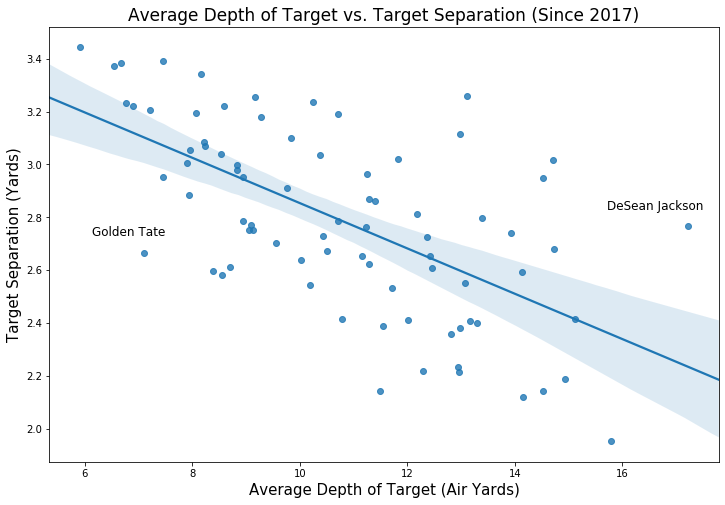

In [246]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.regplot(x= 'Air_Yds', y = 'Separation', data = Final_ES)

ax.set_title('Average Depth of Target vs. Target Separation (Since 2017)', fontsize = 17)
ax.set_ylabel('Target Separation (Yards)', fontsize = 15)
fig.text(17.5, 2.83, "DeSean Jackson", horizontalalignment='right', size='large', color='black', weight='medium')
fig.text(7.5, 2.73, "Golden Tate", horizontalalignment='right', size='large', color='black', weight='medium')

A = ax.set_xlabel('Average Depth of Target (Air Yards)', fontsize = 15)

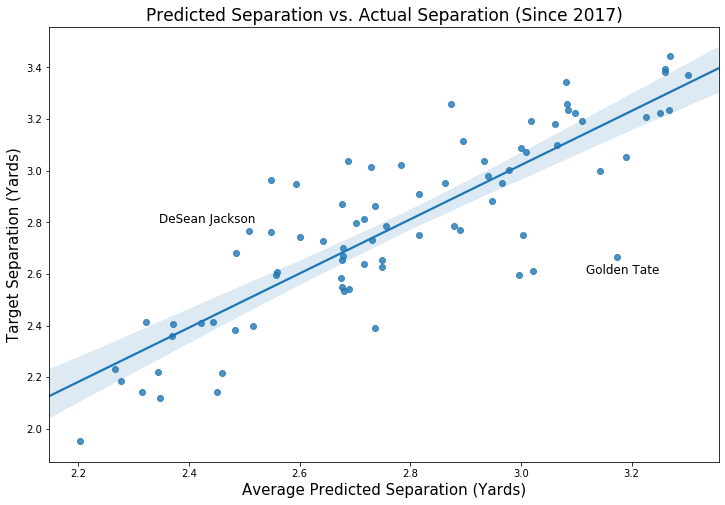

In [258]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.regplot(x= 'Pred_Sep', y = 'Separation', data = Final_ES)

ax.set_title('Predicted Separation vs. Actual Separation (Since 2017)', fontsize = 17)
ax.set_ylabel('Target Separation (Yards)', fontsize = 15)
fig.text(2.52, 2.8, "DeSean Jackson", horizontalalignment='right', size='large', color='black', weight='medium')
fig.text(3.25, 2.60, "Golden Tate", horizontalalignment='right', size='large', color='black', weight='medium')

A = ax.set_xlabel('Average Predicted Separation (Yards)', fontsize = 15)

# Main Takeaways

   1. Separation Above Expectation is a **better predictor of team success** than Separation
       - Separation Above Expectation has a 0.66 correlation to Win % vs .48 for Avg Separation
   2. Receiver Separation must be compared holistically by controlling for factors like depth of target, pre-snap cushion, and nearest defender
       - **Tyreek Hill, Davante Adams, Cooper Kupp, and Tyler Lockett** some of the best route-runners/separation-getters in the NFL.
   3. Compare receviers **within clusters**, and select for positive Separation Above Expectation
       - From a team-building perspective, you cannot replace Antonio Brown with JuJu Smith-Schuster (as we all saw). Players with different body types and abilities have different team roles, and need to be accounted for when building a receiving corps. 

# Potential Improvements

If I had more time/resources/data, what would I do to make these predictions better?

   1. New Feature - Absolute Yardline
      - Absolute yardline (where the play starts from on the field) should be helpful
      - What type of coverage is the defense running? Man v Zone?
   2. New Feature - Time Left + Score Differential 
      - What is the game situation? Is one team down 21 points and playing catch up? Is it tied in the 4th quarter?
   3. Create different model for each position
       - Each position is very specialized, that's the beauty of football
           - This model might not understand all of the nuances of separation for every position, but it can be generalized to be applied to all (non-backfield) receivers. There is always a trade-off between applicability and interpretability. If I build separate models for WRs/TEs/RBs it may be more insightful for each position group, but also inherently more complicated to understand and compare accross positions. 
   4. Hyperparameter tuning
      - In the Light Gradient Boosted Model, hyperparameter tuning is time-consuming and computationally heavy. With more time, I would spend more time fine-tuning these paramters to create the most accurate model
   5. Targets only
      - This dataset only includes instances when the player was targeted, so it has limitations. If we wanted to include all routes, we would have to create a proxy for separation (perhaps at pass forward). 
   
   

## Thanks for reading!

Thank you all for reading. If you have any questions, suggestions, or any feedback at all, feel free to reach out at JesseDCohen@gmail.com. 